# Exploring Countries that may need Humanitarian Help


## Problem Description


In order to determine what countries may need humanitarian help at the moment, a clustering analysis may be a good starting point.

Given a dataset with information about 167 countries, the goal of this experiment is to segmentate the countries in clusters to then determine which groups may need help more urgently.


## How to execute this notebook

1. Creating a Python environment is encouraged:

- With **Conda**: `conda create -n countries-clustering python=3.11`

2. Install requirements:

- `pip install -r requirements.txt`


## Data Exploration


In [1]:
import pandas as pd

df = pd.read_csv('../data/country-data.csv')
df.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [2]:
df.shape

(167, 10)

In [3]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [4]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [5]:
categorical_features = df.select_dtypes(include='object').columns.tolist()
numerical_features = df.select_dtypes(exclude='object').columns.tolist()

print('Categorical Features: ', *categorical_features)
print('Numerical Features: ', *numerical_features)

Categorical Features:  country
Numerical Features:  child_mort exports health imports income inflation life_expec total_fer gdpp


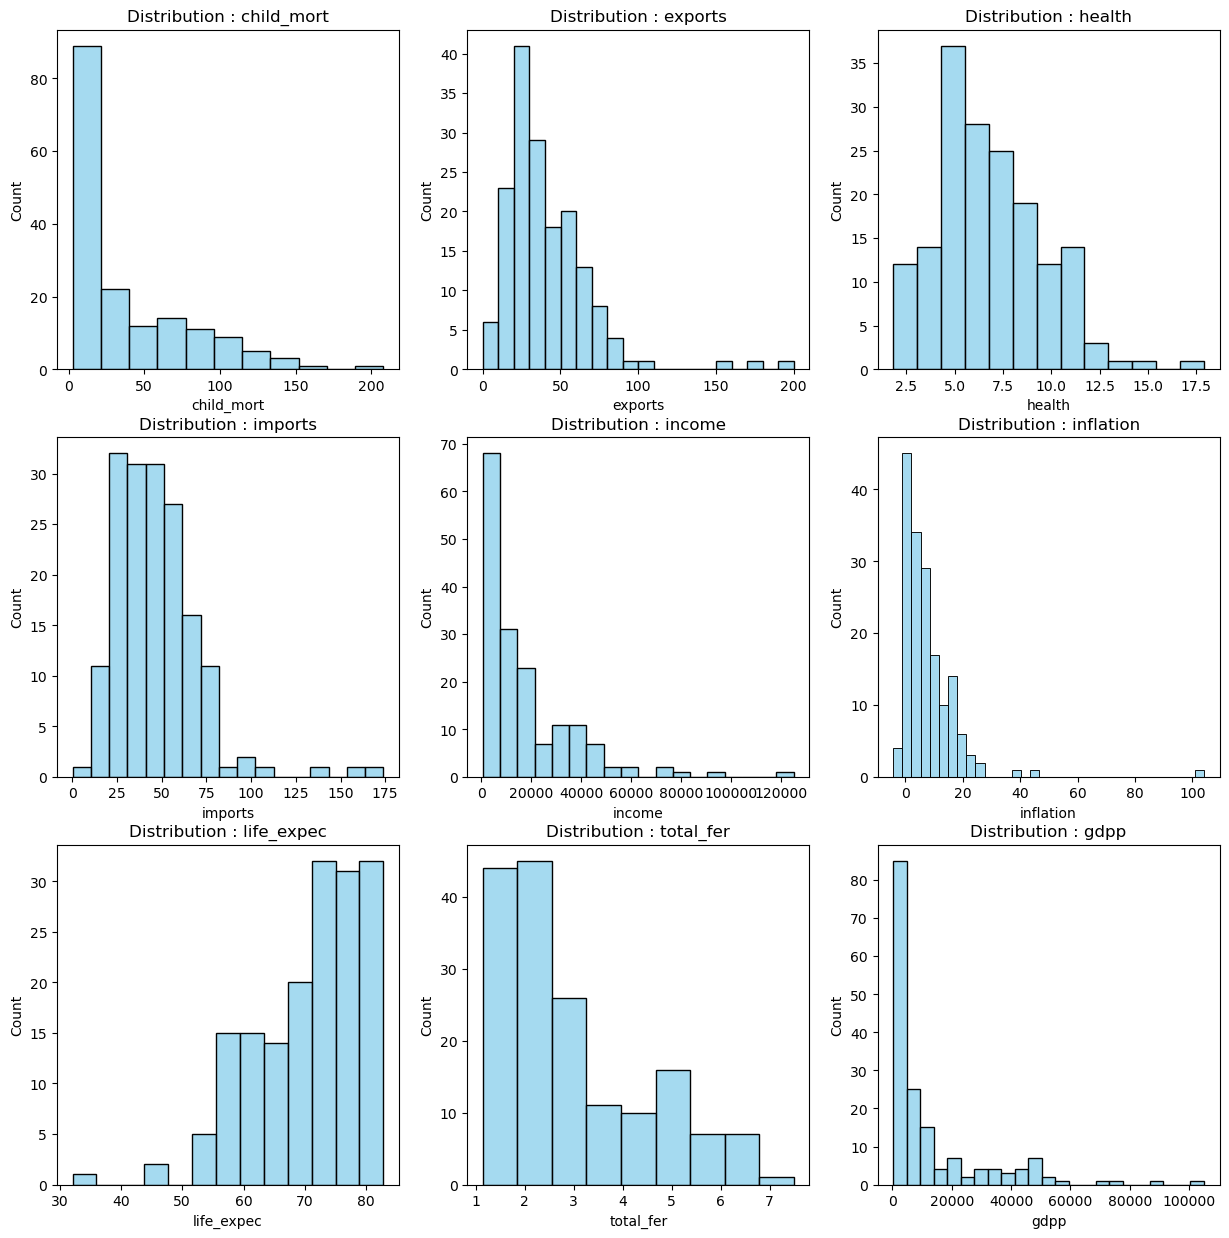

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows = 3,ncols = 3,figsize = (15,15))
for i in range(len(numerical_features)):
    plt.subplot(3,3,i+1)
    sns.histplot(df[numerical_features[i]],color = 'skyblue')
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()

## Data Preprocessing


In [7]:
# Remove the categorical features
countries = df.pop('country')

In [8]:
# Normalize data with the `MaxAbsScaler` method
from sklearn.preprocessing import MaxAbsScaler

df = pd.DataFrame(MaxAbsScaler().fit_transform(df),
                  columns=df.columns)

df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,0.183991,0.205545,0.380765,0.269484,0.137158,0.074825,0.852122,0.393587,0.123468
std,0.193889,0.137060,0.153455,0.139136,0.154225,0.101641,0.107405,0.202116,0.174559
min,0.012500,0.000545,0.101117,0.000379,0.004872,-0.040481,0.387681,0.153538,0.002200
25%,0.039663,0.119000,0.274860,0.173563,0.026840,0.017404,0.788647,0.239653,0.012667
50%,0.092788,0.175000,0.353073,0.248851,0.079680,0.051827,0.882850,0.321762,0.044381
75%,0.298558,0.256750,0.480447,0.337644,0.182400,0.103365,0.927536,0.518024,0.133810
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Clustering


### KMeans


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

models_and_sil = []

for n_cls in range(2, 6):
    kmeans = KMeans(n_clusters=n_cls)
    kmeans.fit(df.values)
    models_and_sil.append({
        'model': kmeans,
        'sil_values': silhouette_samples(df, kmeans.labels_),
        'sil_avg': silhouette_score(df, kmeans.labels_)
    })

In [10]:
best_model = max(filter(lambda x: all(
    i >= 0 for i in x['sil_values']), models_and_sil), key=lambda x: x['sil_avg'])
kmeans = best_model['model']
n_clusters = kmeans.n_clusters
sil_values = best_model['sil_values']
sil_avg = best_model['sil_avg']

df['cluster'] = kmeans.labels_
df['country'] = countries

print('Best model:')
print(f'Clusters -- {n_clusters} clusters')
print(f'Silhouette Average -- {sil_avg}\n\n')
print('Cluster 0:')
print(f"{df[df['cluster']==0].describe()}\n\n")
print('Cluster 1:')
print(f"{df[df['cluster']==1].describe()}")

Best model:
Clusters -- 2 clusters
Silhouette Average -- 0.3290081688910762


Cluster 0:
       child_mort    exports     health    imports     income  inflation  \
count   63.000000  63.000000  63.000000  63.000000  63.000000  63.000000   
mean     0.383410   0.146651   0.344693   0.246238   0.032819   0.101951   
std      0.179824   0.091873   0.151394   0.106825   0.040219   0.131870   
min      0.083654   0.000545   0.110056   0.000379   0.004872   0.008510   
25%      0.261779   0.083250   0.251117   0.171264   0.011720   0.035962   
50%      0.359135   0.119000   0.293296   0.231609   0.019520   0.068654   
75%      0.502404   0.197000   0.425419   0.300000   0.037840   0.127404   
max      1.000000   0.429000   0.793296   0.580460   0.269600   1.000000   

       life_expec  total_fer       gdpp  cluster  
count   63.000000  63.000000  63.000000     63.0  
mean     0.742083   0.608070   0.018694      0.0  
std      0.083840   0.163925   0.024903      0.0  
min      0.387681   0.

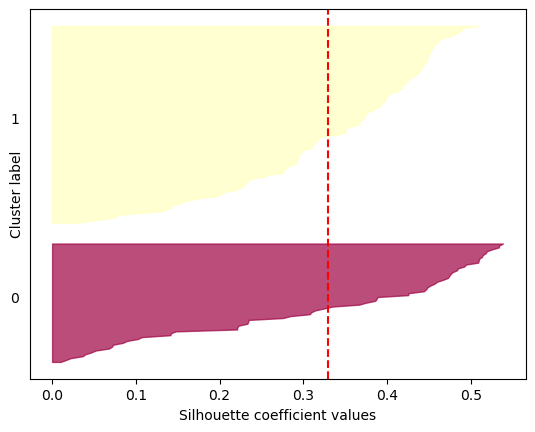

In [11]:
import numpy as np

fig, ax = plt.subplots()
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sil_values[kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.colormaps.get_cmap('Spectral')(i / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_xlabel('Silhouette coefficient values')
ax.set_ylabel('Cluster label')
ax.axvline(x=sil_avg, color='red', linestyle='--')
ax.set_yticks([])
plt.show()

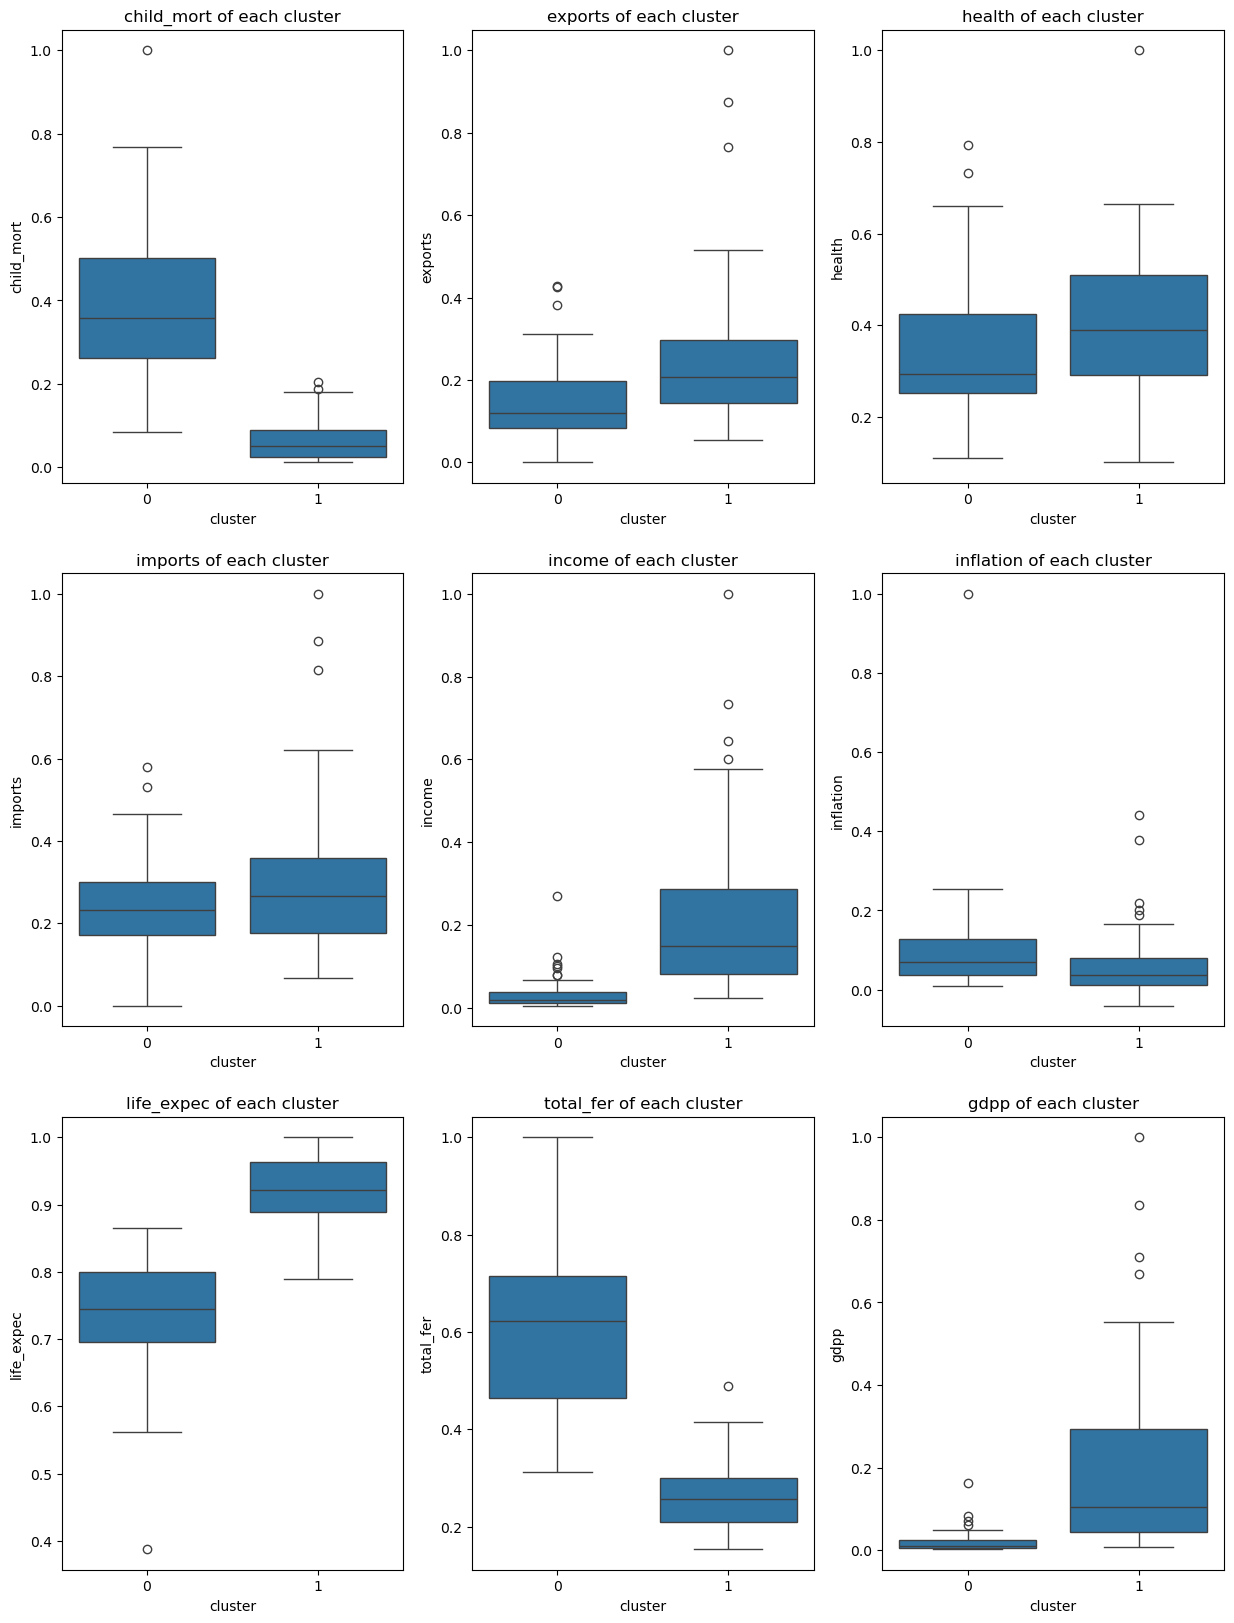

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))

plt.subplot(3, 3, 1)
sns.boxplot(x='cluster', y='child_mort', data=df)
plt.title('child_mort of each cluster')

plt.subplot(3, 3, 2)
sns.boxplot(x='cluster', y='exports', data=df)
plt.title('exports of each cluster')

plt.subplot(3, 3, 3)
sns.boxplot(x='cluster', y='health', data=df)
plt.title('health of each cluster')

plt.subplot(3, 3, 4)
sns.boxplot(x='cluster', y='imports', data=df)
plt.title('imports of each cluster')

plt.subplot(3, 3, 5)
sns.boxplot(x='cluster', y='income', data=df)
plt.title('income of each cluster')

plt.subplot(3, 3, 6)
sns.boxplot(x='cluster', y='inflation', data=df)
plt.title('inflation of each cluster')

plt.subplot(3, 3, 7)
sns.boxplot(x='cluster', y='life_expec', data=df)
plt.title('life_expec of each cluster')

plt.subplot(3, 3, 8)
sns.boxplot(x='cluster', y='total_fer', data=df)
plt.title('total_fer of each cluster')

plt.subplot(3, 3, 9)
sns.boxplot(x='cluster', y='gdpp', data=df)
plt.title('gdpp of each cluster')

plt.show()

In [13]:
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

fig = px.choropleth(df[['country', 'cluster']],
                    locationmode='country names',
                    locations='country',
                    title='Which Countries may need Humanitary Help',
                    color='cluster')
fig.update_geos(fitbounds='locations', visible=True)
fig.update_layout(legend_title_text='Legend',
                  legend_title_side='top', title_pad_l=260, title_y=0.86)
fig.show(engine='kaleido')

In [14]:
# Drop cluster and country columns to keep working on the same dataset
df = df.drop(columns=['cluster', 'country'])
df.head(5)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.433654,0.0500,0.423464,0.258046,0.01288,0.090769,0.678744,0.777036,0.005267
1,0.079808,0.1400,0.365922,0.279310,0.07944,0.043173,0.921498,0.220294,0.038952
2,0.131250,0.1920,0.232961,0.180460,0.10320,0.154808,0.923913,0.385848,0.042476
3,0.572115,0.3115,0.159218,0.246552,0.04720,0.215385,0.725845,0.822430,0.033619
4,0.049519,0.2275,0.336872,0.338506,0.15280,0.013846,0.927536,0.284379,0.116190


### Hierarchical Clustering


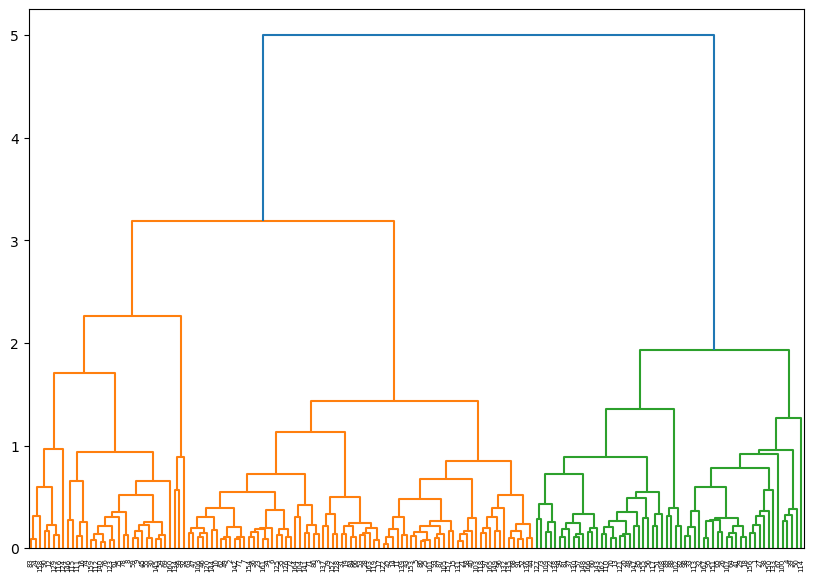

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 7))
dendrogram(linkage(df, metric='euclidean', method='ward'),
           orientation='top',
           labels=range(1, df.shape[0]+1),
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()

Observing the dendogram, we can conclude that we may want to select 2 clusters for the Agglomerative approach.


In [16]:
from sklearn.cluster import AgglomerativeClustering

aggl = AgglomerativeClustering(
    n_clusters=2, metric='euclidean', linkage='ward')
aggl.fit(df)

df['cluster'] = aggl.labels_
df['country'] = countries

print('Cluster 0:')
print(f"{df[df['cluster']==0].describe()}\n\n")
print('Cluster 1:')
print(f"{df[df['cluster']==1].describe()}")

Cluster 0:
       child_mort     exports      health     imports      income   inflation  \
count  109.000000  109.000000  109.000000  109.000000  109.000000  109.000000   
mean     0.066337    0.238674    0.400579    0.287145    0.192647    0.056296   
std      0.047666    0.145658    0.148791    0.151626    0.163381    0.071759   
min      0.012500    0.053500    0.101117    0.067816    0.014240   -0.040481   
25%      0.026442    0.142500    0.290503    0.178161    0.077760    0.010865   
50%      0.051923    0.211500    0.386034    0.275287    0.142400    0.035385   
75%      0.091827    0.289000    0.503352    0.357471    0.271200    0.071827   
max      0.213462    1.000000    1.000000    1.000000    1.000000    0.441346   

       life_expec   total_fer        gdpp  cluster  
count  109.000000  109.000000  109.000000    109.0  
mean     0.913719    0.275952    0.179541      0.0  
std      0.054876    0.085621    0.193259      0.0  
min      0.745169    0.153538    0.007486      

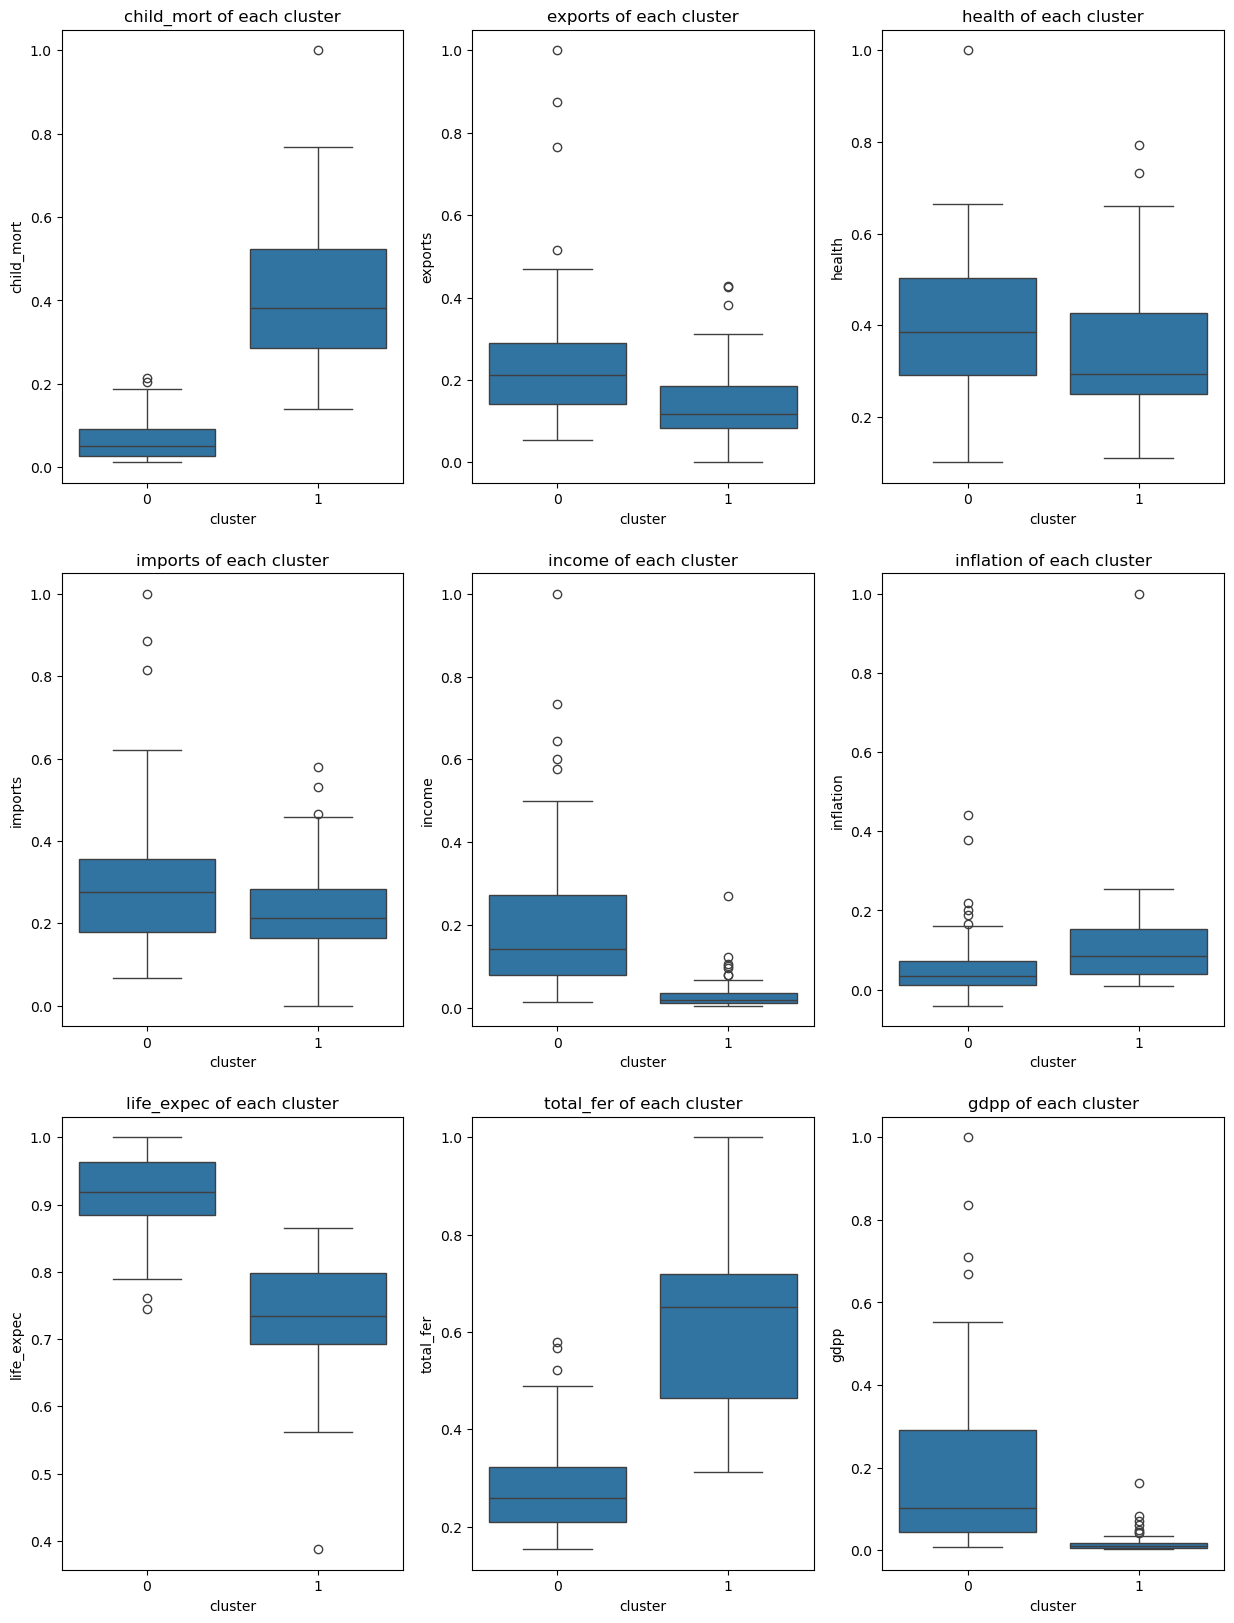

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))

plt.subplot(3, 3, 1)
sns.boxplot(x='cluster', y='child_mort', data=df)
plt.title('child_mort of each cluster')

plt.subplot(3, 3, 2)
sns.boxplot(x='cluster', y='exports', data=df)
plt.title('exports of each cluster')

plt.subplot(3, 3, 3)
sns.boxplot(x='cluster', y='health', data=df)
plt.title('health of each cluster')

plt.subplot(3, 3, 4)
sns.boxplot(x='cluster', y='imports', data=df)
plt.title('imports of each cluster')

plt.subplot(3, 3, 5)
sns.boxplot(x='cluster', y='income', data=df)
plt.title('income of each cluster')

plt.subplot(3, 3, 6)
sns.boxplot(x='cluster', y='inflation', data=df)
plt.title('inflation of each cluster')

plt.subplot(3, 3, 7)
sns.boxplot(x='cluster', y='life_expec', data=df)
plt.title('life_expec of each cluster')

plt.subplot(3, 3, 8)
sns.boxplot(x='cluster', y='total_fer', data=df)
plt.title('total_fer of each cluster')

plt.subplot(3, 3, 9)
sns.boxplot(x='cluster', y='gdpp', data=df)
plt.title('gdpp of each cluster')

plt.show()

In [18]:
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

fig = px.choropleth(df[['country', 'cluster']],
                    locationmode='country names',
                    locations='country',
                    title='Which Countries may need Humanitary Help',
                    color='cluster')
fig.update_geos(fitbounds='locations', visible=True)
fig.update_layout(legend_title_text='Legend',
                  legend_title_side='top', title_pad_l=260, title_y=0.86)
fig.show(engine='kaleido')

In [19]:
# Drop cluster and country columns to keep working on the same dataset
df = df.drop(columns=['cluster', 'country'])
df.head(5)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.433654,0.0500,0.423464,0.258046,0.01288,0.090769,0.678744,0.777036,0.005267
1,0.079808,0.1400,0.365922,0.279310,0.07944,0.043173,0.921498,0.220294,0.038952
2,0.131250,0.1920,0.232961,0.180460,0.10320,0.154808,0.923913,0.385848,0.042476
3,0.572115,0.3115,0.159218,0.246552,0.04720,0.215385,0.725845,0.822430,0.033619
4,0.049519,0.2275,0.336872,0.338506,0.15280,0.013846,0.927536,0.284379,0.116190


### Gaussian Mixture Models


In [20]:
from sklearn.mixture import GaussianMixture

models_and_bic = []

for n_cmps in range(2, 10):
    gmm = GaussianMixture(n_components=n_cmps, random_state=42)
    gmm.fit(df)
    models_and_bic.append({
        'model': gmm,
        'bic': gmm.bic(df),
    })

models_and_bic

[{'model': GaussianMixture(n_components=2, random_state=42),
  'bic': -3228.3806773366255},
 {'model': GaussianMixture(n_components=3, random_state=42),
  'bic': -3296.4432233966454},
 {'model': GaussianMixture(n_components=4, random_state=42),
  'bic': -3270.1514969029417},
 {'model': GaussianMixture(n_components=5, random_state=42),
  'bic': -3138.034760827147},
 {'model': GaussianMixture(n_components=6, random_state=42),
  'bic': -3102.4077870347974},
 {'model': GaussianMixture(n_components=7, random_state=42),
  'bic': -3093.173217418817},
 {'model': GaussianMixture(n_components=8, random_state=42),
  'bic': -2855.0130789317363},
 {'model': GaussianMixture(n_components=9, random_state=42),
  'bic': -2714.6262601839594}]

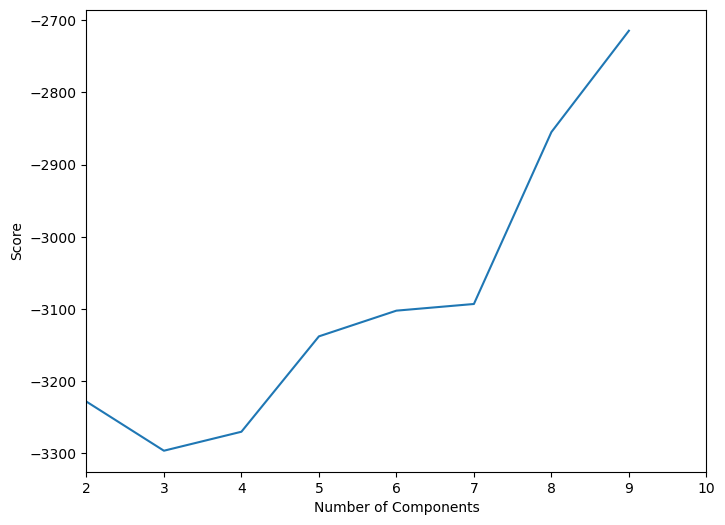

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
g = sns.lineplot(y=list(map(lambda x: x['bic'], models_and_bic)), x=list(
    map(lambda x: x['model'].n_components, models_and_bic)), markers=True)
plt.xlabel('Number of Components')
plt.ylabel('Score')
g.set_xlim(2, 10)
plt.show()

In [22]:
best_model = models_and_bic[1]
gmm = best_model['model']
n_components = gmm.n_components
bic = best_model['bic']
labels = gmm.predict(df)

df['cluster'] = labels
df['country'] = countries

print('Best model:')
print(f'Clusters -- {n_clusters} clusters')
print('Cluster 0:')
print(f"{df[df['cluster']==0].describe()}\n\n")
print('Cluster 1:')
print(f"{df[df['cluster']==1].describe()}")

Best model:
Clusters -- 2 clusters
Cluster 0:
       child_mort    exports     health    imports     income  inflation  \
count   58.000000  58.000000  58.000000  58.000000  58.000000  58.000000   
mean     0.074196   0.211190   0.366086   0.271274   0.117655   0.061812   
std      0.036870   0.098753   0.105118   0.112214   0.047449   0.073669   
min      0.016346   0.053500   0.145810   0.067816   0.035920  -0.040481   
25%      0.048317   0.139125   0.283799   0.181897   0.079380   0.014231   
50%      0.070913   0.182000   0.369553   0.279598   0.114800   0.042933   
75%      0.094231   0.261125   0.438547   0.348563   0.152000   0.081875   
max      0.165385   0.469000   0.620112   0.620690   0.236800   0.441346   

       life_expec  total_fer       gdpp  cluster  
count   58.000000  58.000000  58.000000     58.0  
mean     0.902195   0.264744   0.078796      0.0  
std      0.031739   0.062575   0.046880      0.0  
min      0.826087   0.166889   0.012476      0.0  
25%      0.885

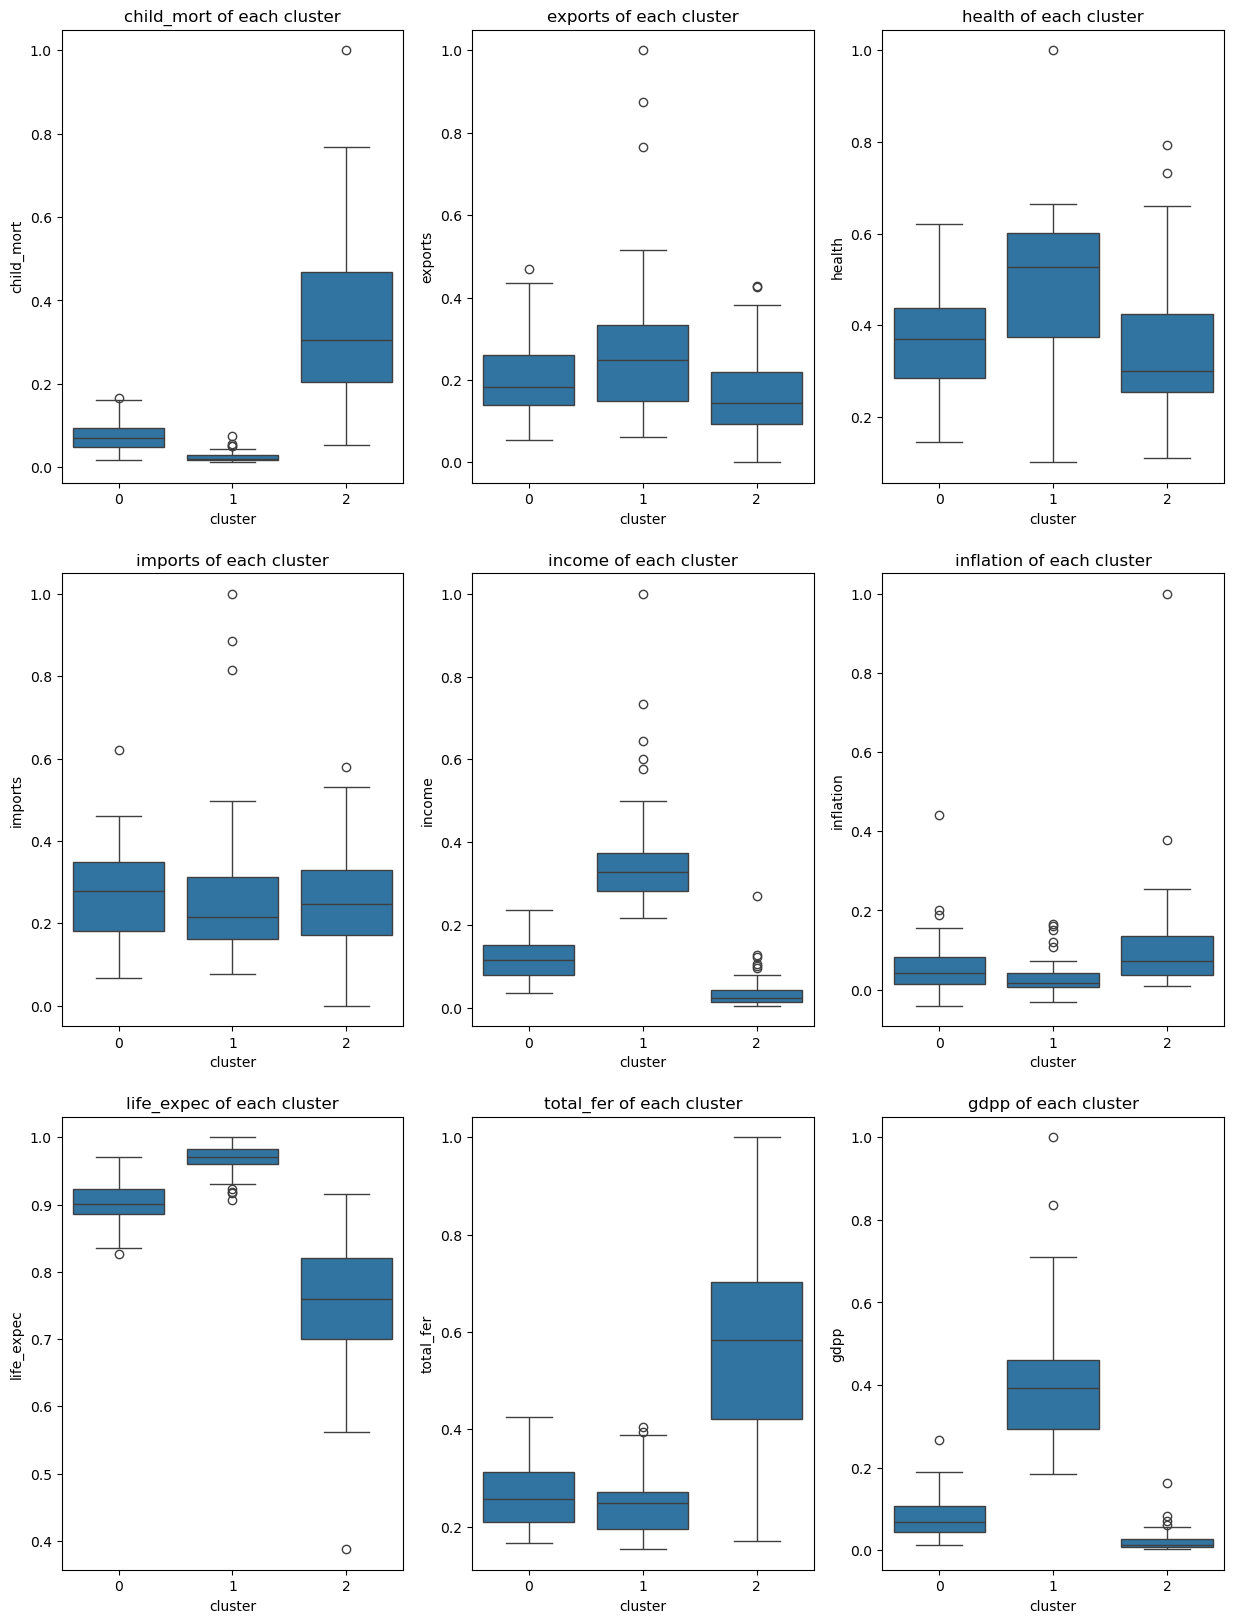

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))

plt.subplot(3, 3, 1)
sns.boxplot(x='cluster', y='child_mort', data=df)
plt.title('child_mort of each cluster')

plt.subplot(3, 3, 2)
sns.boxplot(x='cluster', y='exports', data=df)
plt.title('exports of each cluster')

plt.subplot(3, 3, 3)
sns.boxplot(x='cluster', y='health', data=df)
plt.title('health of each cluster')

plt.subplot(3, 3, 4)
sns.boxplot(x='cluster', y='imports', data=df)
plt.title('imports of each cluster')

plt.subplot(3, 3, 5)
sns.boxplot(x='cluster', y='income', data=df)
plt.title('income of each cluster')

plt.subplot(3, 3, 6)
sns.boxplot(x='cluster', y='inflation', data=df)
plt.title('inflation of each cluster')

plt.subplot(3, 3, 7)
sns.boxplot(x='cluster', y='life_expec', data=df)
plt.title('life_expec of each cluster')

plt.subplot(3, 3, 8)
sns.boxplot(x='cluster', y='total_fer', data=df)
plt.title('total_fer of each cluster')

plt.subplot(3, 3, 9)
sns.boxplot(x='cluster', y='gdpp', data=df)
plt.title('gdpp of each cluster')

plt.show()

In [24]:
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

fig = px.choropleth(df[['country', 'cluster']],
                    locationmode='country names',
                    locations='country',
                    title='Which Countries may need Humanitary Help',
                    color='cluster')
fig.update_geos(fitbounds='locations', visible=True)
fig.update_layout(legend_title_text='Legend',
                  legend_title_side='top', title_pad_l=260, title_y=0.86)
fig.show(engine='kaleido')